In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import os
import random
from datetime import datetime
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import sys

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
file_path = 'outputfile.txt'
sys.stdout = open(file_path, "w")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where










In [3]:
df_Gold = pd.read_csv('Gold Futures Historical Data.csv')

In [4]:
df_Crude = pd.read_csv('Crude Oil WTI Futures Historical Data.csv')

In [5]:
df = pd.read_csv('Try-3.csv')

In [6]:
df.shape

(11307, 269)

In [7]:
df['DATE'] = pd.to_datetime(df['date'] )
df_Crude['DATE'] = pd.to_datetime(df_Crude['Date'] )
df_Gold['DATE'] = pd.to_datetime(df_Gold['Date'] )

In [8]:
df.set_index(["DATE"],inplace=True)
df.drop(['date'], axis=1, inplace=True)

df_Gold.set_index(["DATE"],inplace=True)
df_Gold.drop(['Date'], axis=1, inplace=True)

df_Crude.set_index(["DATE"],inplace=True)
df_Crude.drop(['Date'], axis=1, inplace=True)

In [9]:
df_Gold = df_Gold.iloc[::-1]
df_Crude = df_Crude.iloc[::-1]


In [10]:
Stock_name = df['symbol'].unique()

In [11]:
df_SandP = pd.read_csv('S&P 500 Historical Data.csv')
df_Nasdaq = pd.read_csv('Nasdaq Historical Data.csv')
df_DJIA = pd.read_csv('Dow Jones Industrial Average Historical Data.csv')

In [12]:
df_SandP['DATE'] = pd.to_datetime(df_SandP['Date'])
df_Nasdaq['DATE'] = pd.to_datetime(df_Nasdaq['Date'])
df_DJIA['DATE'] = pd.to_datetime(df_DJIA['Date'])
df_Nasdaq.rename(columns = {'Close':'Price'},inplace = True)

In [13]:
df_SandP.set_index(["DATE"],inplace=True)
df_Nasdaq.set_index(["DATE"],inplace=True)
df_DJIA.set_index(["DATE"],inplace=True)

In [14]:
df_SandP.drop(['Date'], axis=1, inplace=True)
df_Nasdaq.drop(['Date'], axis=1, inplace=True)
df_DJIA.drop(['Date'], axis=1, inplace=True)

In [15]:
df_SandP = df_SandP.iloc[::-1]
df_DJIA = df_DJIA.iloc[::-1]

In [16]:
df_SandP = df_SandP.astype(float, errors = 'ignore')
df_Nasdaq = df_Nasdaq.astype(float, errors = 'ignore')
df_DJIA = df_DJIA.astype(float, errors = 'ignore')

In [17]:
Aa = df['OPrice'].loc[df['symbol'] == Stock_name[0]]
Ag = df['OPrice'].loc[df['symbol'] == Stock_name[1]]
In = df['OPrice'].loc[df['symbol'] == Stock_name[2]]
Crude = df_Crude['Price']

df_Gold['Price'] = df_Gold['Price'].apply(lambda x: str(x.replace(',','')))
df_Gold['Price'] = df_Gold['Price'].astype(float, errors = 'ignore')
Gold = df_Gold['Price']

In [18]:
df_SandP = df_SandP.applymap(lambda x: str(x. replace(',','')))
df_DJIA = df_DJIA.applymap(lambda x: str(x. replace(',','')))

In [19]:
df_List = [df_SandP,df_Nasdaq,df_DJIA]

In [20]:
for column in Stock_name:
    df_Target = df['OPrice'].loc[df['symbol'] == column]
    for df_Feat in df_List:
        df_Feat['Price'] = df_Feat['Price'].astype(float, errors = 'ignore')
        df_Feat['Open'] = df_Feat['Open'].astype(float, errors = 'raise')
        df_Feat['Low'] = df_Feat['Low'].astype(float, errors = 'raise')
        df_Feat['High'] = df_Feat['High'].astype(float, errors = 'raise')


In [21]:
df_SandP = df_SandP.interpolate()
df_Nasdaq = df_Nasdaq.interpolate()
df_DJIA = df_DJIA.interpolate()

In [22]:
### Indicators ###
def simple_moving_average(df):
    df['SMA_5'] = df['Open'].transform(lambda x:x.rolling(window = 5).mean())
    df['SMA_15'] = df['Open'].transform(lambda x:x.rolling(window = 15).mean())
    df['SMA_30'] = df['Open'].transform(lambda x:x.rolling(window = 30).mean())
    df['SMA_60'] = df['Open'].transform(lambda x:x.rolling(window = 60).mean())

    df['SMA_ratio'] = df['SMA_60'] / df['SMA_5']
    
    return df

def MACD(df):
    df['ewm_15'] = df['Open'].transform(lambda x:x.ewm(span=15, adjust = False).mean())
    df['ewm_30'] = df['Open'].transform(lambda x:x.ewm(span=30, adjust = False).mean())
    df['MACD'] = df['ewm_30'] - df['ewm_15']
    return df

def stochastic_oscillators(df):
    df['LOWEST15D'] = df['Low'].transform(lambda x:x.rolling(window = 15).min())
    df['HIGHEST15D'] = df['High'].transform(lambda x:x.rolling(window = 15).max())
    
    df['LOWEST30D'] = df['Low'].transform(lambda x:x.rolling(window = 30).min())
    df['HIGHEST30D'] = df['High'].transform(lambda x:x.rolling(window = 30).max())

    df['Stochastic_15'] = ((df['Open'] - df['LOWEST15D'])/(df['HIGHEST15D'] - df['LOWEST15D']))*100
    df['Stochastic_30'] = ((df['Open'] - df['LOWEST30D'])/(df['HIGHEST30D'] - df['LOWEST30D']))*100
    
    df['Stochastic_%D_15'] = df['Stochastic_15'].rolling(window = 15).mean()
    df['Stochastic_%D_30'] = df['Stochastic_30'].rolling(window = 30).mean()
    
    df['Stochastic_Ratio'] = df['Stochastic_%D_15']/df['Stochastic_%D_30']
    return df

def ROC(df):
    df['RC_5'] = df['Open'].transform(lambda x: x.pct_change(periods = 5)) 
    df['RC_15'] = df['Open'].transform(lambda x: x.pct_change(periods = 15)) 
    df['RC_30'] = df['Open'].transform(lambda x: x.pct_change(periods = 30)) 
    df['RC_60'] = df['Open'].transform(lambda x: x.pct_change(periods = 60)) 
    return df

    
import talib as ta

def RSI(df):
    df['RSI_5']=ta.RSI(np.array(df['Open']), timeperiod=5)
    df['RSI_15']=ta.RSI(np.array(df['Open']), timeperiod=15)
    df['RSI_30']=ta.RSI(np.array(df['Open']), timeperiod=30)
    df['RSI_60']=ta.RSI(np.array(df['Open']), timeperiod=60)
    return df
    
def ADX(df):
    df['ADX_5']=ta.ADX(np.array(df['High']),np.array(df['Low']), np.array(df['Open']), timeperiod =5)
    df['ADX_15']=ta.ADX(np.array(df['High']),np.array(df['Low']), np.array(df['Open']), timeperiod =15)
    df['ADX_30']=ta.ADX(np.array(df['High']),np.array(df['Low']), np.array(df['Open']), timeperiod =30)
    df['ADX_60']=ta.ADX(np.array(df['High']),np.array(df['Low']), np.array(df['Open']), timeperiod =60)
    return df

    

In [23]:
for df_temp in [df_SandP,df_DJIA,df_Nasdaq]:
    df_temp = simple_moving_average(df_temp)
    df_temp = MACD(df_temp)
    df_temp = stochastic_oscillators(df_temp)
    df_temp = ADX(df_temp)
    df_temp = ROC(df_temp)
    df_temp = RSI(df_temp)
    

In [24]:
df_SandP = df_SandP.fillna(0)
df_Nasdaq = df_Nasdaq.fillna(0)
df_DJIA = df_DJIA.fillna(0)

In [25]:
for df_Feat in [df_SandP,df_DJIA,df_Nasdaq]:
    for i in Crude.index:
        if i in df_Feat.index:
            df_Feat.loc[i,'Crude'] = Crude.loc[i]

for df_Feat in [df_SandP,df_DJIA,df_Nasdaq]:
    for i in Gold.index:
        if i in df_Feat.index:
            df_Feat.loc[i,'Gold'] = Gold.loc[i]

In [26]:
for column in Stock_name:
    df_Target = df['OPrice'].loc[df['symbol'] == column]
    for df_Feat in [df_SandP,df_DJIA,df_Nasdaq]:
        for i in df_Target.index:
            df_Feat.loc[i,column] = df_Target.loc[i]

In [27]:
df_SandP = df_SandP.drop(['Change %','Vol.','AAPL'],axis = 1)
df_SandP = df_SandP[df_SandP.index < '2012-01-01'] 
df_SandP = df_SandP[df_SandP.index > '2001-01-01']

df_DJIA = df_DJIA.drop(['Change %','AAPL'],axis = 1)
df_DJIA = df_DJIA[df_DJIA.index < '2012-01-01']
df_DJIA = df_DJIA[df_DJIA.index > '2001-01-01']

df_Nasdaq = df_Nasdaq.drop(['AAPL'],axis = 1)
df_Nasdaq = df_Nasdaq[df_Nasdaq.index < '2012-01-01']
df_Nasdaq = df_Nasdaq[df_Nasdaq.index > '2001-01-01']

In [28]:
df_SandP = df_SandP.interpolate()
df_Nasdaq = df_Nasdaq.interpolate()
df_DJIA = df_DJIA.interpolate()

df_SandP = df_SandP.iloc[1:,:]
df_Nasdaq = df_Nasdaq.iloc[1:,:]

df_DJIA = df_DJIA.iloc[1:,:]

In [29]:
df_Nasdaq = df_Nasdaq.drop(["Volume","Adj Close"],axis=1)
df_DJIA = df_DJIA.drop(["Vol."],axis=1)

In [30]:
def datagen(df,seq_len,batch_size,columns):
    X_train = df[columns].iloc[0:round(0.7*(len(df.index)))]
    batch = []
    index = X_train.index
    columns_list = [c for c in columns]
    while True:
        while True:
            t = random.choice(index)
            n = (X_train.index == t).argmax()
            if n-seq_len+1 < 0:
                continue
            frame = df.iloc[n-seq_len+1:n+1]
            batch.append([frame[columns_list].values, df.loc[t,["AMGN","INTC"]]])
            break
        if len(batch) == batch_size:
            X, y = zip(*batch)
            X, y = np.expand_dims(np.array(X),3),np.array(y)
            yield X, y
            batch = []

In [31]:
def testgen(df,seq_len,columns):
    batch = []
    columns_list = [c for c in columns]
    target_list = ['AMGN','INTC']
    X_temp = df[columns].iloc[round(0.7*(len(df.index))):]
    t = X_temp.index[0]
    n = (df.index == t).argmax()
    for i in range(n+1, len(df)+1):
        frame = df.iloc[i-seq_len:i]
        batch.append([frame[columns_list].values,frame[["AMGN","INTC"]].iloc[0].values])
    X, y = zip(*batch)
    return np.expand_dims(np.array(X),3), np.array(y)
    

In [32]:
def cnnpred_3d(seq_len=60, n_features=35, n_filters=(8,8,8), droprate=0.30):
    "3D-CNNpred model according to the paper"
    model = Sequential([
        Input(shape=(seq_len, n_features, 1)),
        Conv2D(n_filters[0], kernel_size=(1,1), activation="relu", data_format="channels_last"),
        Conv2D(n_filters[1], kernel_size=(1,3), activation="relu"),
        MaxPool2D(pool_size=(1,2)),
        Flatten(),
        Dropout(droprate),
        Dense(2, activation="relu")
    ])
    return model

In [33]:
def MSE(y_true,y_pred):
    MSE_score = mse(y_true,y_pred)
    return MSE_score

In [34]:
def CNN_Model(df):
    seq_len    = 60
    batch_size = 128
    n_epochs   = 30
    n_features = 35
    n_stocks   = 1
    model = cnnpred_3d(seq_len, n_features)
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    model.summary()
    
    df_train = df.iloc[0:round(0.7*(len(df.index)))]
    columns = df_train.columns
    columns = columns[:-2]
    
    scaler = StandardScaler().fit(df_train[columns])
    df[columns] = scaler.transform(df[columns])
    
    model.fit(datagen(df,seq_len,batch_size,columns),epochs=n_epochs, steps_per_epoch=400, validation_steps=None, verbose=1)
    test_data, test_target = testgen(df, seq_len, columns)
    test_out = model.predict(test_data)
    W = mean_absolute_error(test_out, test_target)
    print("Mean Absolute Error: %.2f", W)
    
    plt.figure(1)
    plt.plot(test_out[:,0],label = "Pred")
    plt.plot(test_target[:,0],label = "Actual")
    plt.legend()
    plt.title("Actual vs. Prediction Plot - AMGEN")
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.show()
    
    plt.figure(2)
    plt.plot(test_out[:,1],label = "Pred")
    plt.plot(test_target[:,1],label = "Actual")
    plt.legend()
    plt.title("Actual vs. Prediction Plot - Intel")
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.show()
    
    return W   

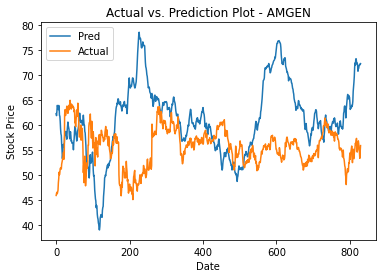

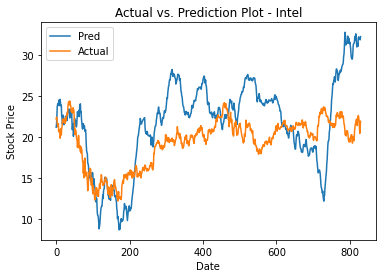

In [35]:
A = CNN_Model(df_SandP)

In [36]:
A

6.033788380856803

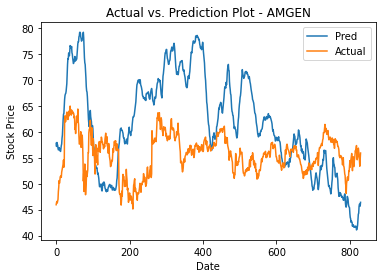

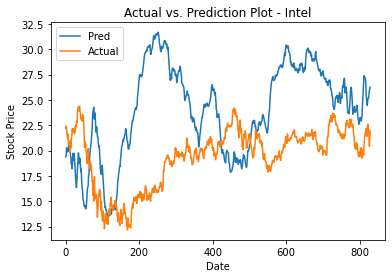

In [37]:
B = CNN_Model(df_Nasdaq)

In [38]:
B

7.586430627124271

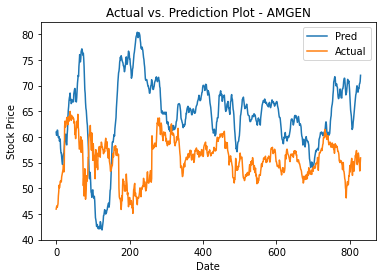

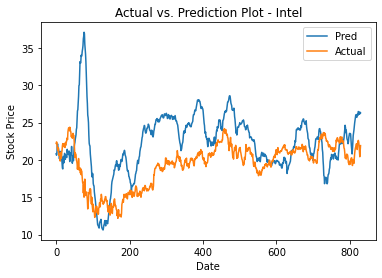

In [39]:
C = CNN_Model(df_DJIA)

In [40]:
C

7.086410064141135

In [41]:
from numpy import split
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
#from  WindowNormalizationDailyPredict import *
import numpy as np
import pandas as pd	
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.regularizers import L1L2
from sklearn.metrics import r2_score, f1_score, mean_squared_error as mse, mean_absolute_error as mae

Using TensorFlow backend.


In [52]:
#lstm
def to_supervised(train, n_input, n_out):
    data=train
    # flatten data
    #data = train.reshape((train.shape[0]*train.shape[1], train.shape[2])) #needed if train is weekly data
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end < len(data):
            X.append(data.loc[data.index[in_start:in_end], :]) #process all columns
            y.append(data.loc[data.index[in_end:out_end], ['AMGN','INTC']]) #leftmost column = Open has the target categories
        # move along one time step
        in_start += 1
    return np.array(X), np.array(y)

<Figure size 432x288 with 0 Axes>

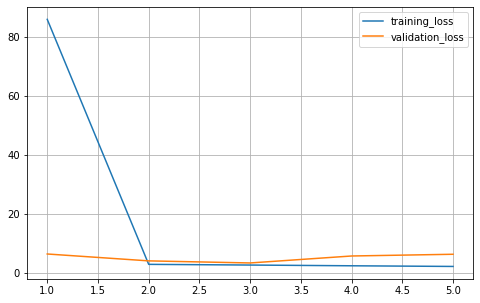

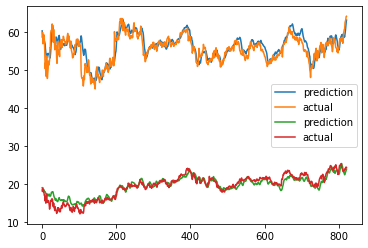

In [53]:
#S&P500


# Data preparation for lstm
train_SandP = df_SandP.iloc[0:round(0.7*(len(df_SandP.index)))]
test_SandP = df_SandP.iloc[round(0.7*(len(df_SandP.index))):]

n_input = 7

X_train_SandP, y_train_SandP = to_supervised(train_SandP, n_input, n_out=1)
X_test_SandP, y_test_SandP = to_supervised(test_SandP, n_input, n_out=1)
alpha = y_train_SandP.reshape(y_train_SandP.shape[0], y_train_SandP.shape[1] * y_train_SandP.shape[2])

# define parameters
import keras
verbose, epochs, batch_size = 1, 150, 16 #1,150,16

n_timesteps, n_features, n_outputs = X_train_SandP.shape[1], X_train_SandP.shape[2], alpha.shape[1]

# define model

model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features), return_sequences = True, 
               dropout=0.0, recurrent_dropout=0.0, kernel_regularizer=L1L2(0.0, 0.0)))
model.add(LSTM(200, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0))
model.add(Dense(n_outputs))

model.compile(loss='mse', optimizer='adam')


callbacks_list = [
    ModelCheckpoint(
        filepath="LSTM-weights-best.hdf5",
        monitor = 'val_loss',
        save_best_only=True,
        mode='auto',
        verbose=1
        ),
    ReduceLROnPlateau(
        monitor = 'val_loss',
        factor = 0.1,
        patience=3,
        verbose=1
        ),
    EarlyStopping(
        monitor = 'val_loss',
        patience=2,
        verbose=1
        )
    ]

model.summary()


# fit network
history  = model.fit(X_train_SandP, alpha, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=0.2,callbacks=callbacks_list,shuffle=True)

model = keras.models.load_model("LSTM-weights-best.hdf5")

#############################################################################################################

train_loss_values = history.history["loss"] #training loss
val_loss_values = history.history["val_loss"] #validation loss
epochs = range(1,len(train_loss_values)+1)

plt.clf()

df = pd.DataFrame(train_loss_values, columns=["training_loss"], index=epochs)
df["validation_loss"] = val_loss_values
title="training loss vs validation loss"
df[['training_loss','validation_loss']].plot(grid=True,figsize=(8,5))
plt.show()


print("val_loss_value: ", val_loss_values[-1])



#############################################################################################################

predictions = list()

# make a forecast

for i in range(X_test_SandP.shape[0]):
	# predict the week
	input_x = X_test_SandP[i,:,:]
    # reshape into [1, n_input, n]
	input_x = input_x.reshape(1, input_x.shape[0], input_x.shape[1])   
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	yhat_sequence = yhat
	# store the predictions
	predictions.append(yhat_sequence)
# evaluate predictions days for each week
predictions = np.array(predictions)


actual1 = []
actual2 = []
for i in range(y_test_SandP.shape[0]):
    actual1.append(y_test_SandP[i][0][0])
    actual2.append(y_test_SandP[i][0][1])

pred1 = []
pred2 = []
for i in range(predictions.shape[0]):
    pred1.append(predictions[i][0])
    pred2.append(predictions[i][1])

    
plt.plot(pred1,label = "prediction")
plt.plot(actual1, label = "actual")
plt.legend()
plt.plot()

MAE_Score_test1 = mae(actual1,pred1)
print(MAE_Score_test1)


plt.plot(pred2,label = "prediction")
plt.plot(actual2, label = "actual")
plt.legend()
plt.plot()

MAE_Score_test2 = mae(actual2,pred2)
print(MAE_Score_test2)

<Figure size 432x288 with 0 Axes>

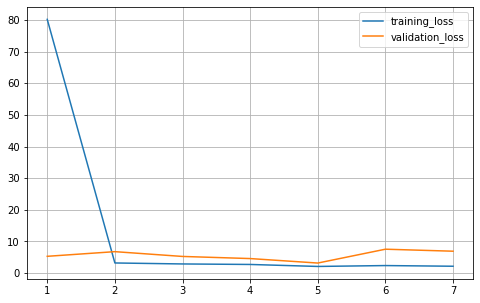

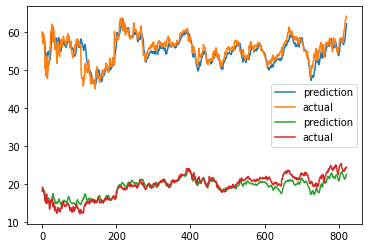

In [54]:

#DJIA


# Data preparation for lstm
train = df_DJIA.iloc[0:round(0.7*(len(df_DJIA.index)))]
test = df_DJIA.iloc[round(0.7*(len(df_DJIA.index))):]

n_input = 7

X_train, y_train = to_supervised(train, n_input, n_out=1)
X_test, y_test = to_supervised(test, n_input, n_out=1)
alpha = y_train.reshape(y_train.shape[0], y_train.shape[1] * y_train.shape[2])

# define parameters
import keras
verbose, epochs, batch_size = 1, 150, 16 #1,150,16

n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], alpha.shape[1]

# define model

model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features), return_sequences = True, 
               dropout=0.0, recurrent_dropout=0.0, kernel_regularizer=L1L2(0.0, 0.0)))
model.add(LSTM(200, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0))
model.add(Dense(n_outputs))

model.compile(loss='mse', optimizer='adam')


callbacks_list = [
    ModelCheckpoint(
        filepath="LSTM-weights-best.hdf5",
        monitor = 'val_loss',
        save_best_only=True,
        mode='auto',
        verbose=1
        ),
    ReduceLROnPlateau(
        monitor = 'val_loss',
        factor = 0.1,
        patience=3,
        verbose=1
        ),
    EarlyStopping(
        monitor = 'val_loss',
        patience=2,
        verbose=1
        )
    ]

model.summary()


# fit network
history  = model.fit(X_train, alpha, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=0.2,callbacks=callbacks_list,shuffle=True)

model = keras.models.load_model("LSTM-weights-best.hdf5")

#############################################################################################################

train_loss_values = history.history["loss"] #training loss
val_loss_values = history.history["val_loss"] #validation loss
epochs = range(1,len(train_loss_values)+1)

plt.clf()

df = pd.DataFrame(train_loss_values, columns=["training_loss"], index=epochs)
df["validation_loss"] = val_loss_values
title="training loss vs validation loss"
df[['training_loss','validation_loss']].plot(grid=True,figsize=(8,5))
plt.show()


print("val_loss_value: ", val_loss_values[-1])



#############################################################################################################

predictions = list()

# make a forecast

for i in range(X_test.shape[0]):
	# predict the week
	input_x = X_test[i,:,:]
    # reshape into [1, n_input, n]
	input_x = input_x.reshape(1, input_x.shape[0], input_x.shape[1])   
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	yhat_sequence = yhat
	# store the predictions
	predictions.append(yhat_sequence)
# evaluate predictions days for each week
predictions = np.array(predictions)


actual1 = []
actual2 = []
for i in range(y_test.shape[0]):
    actual1.append(y_test[i][0][0])
    actual2.append(y_test[i][0][1])

pred1 = []
pred2 = []
for i in range(predictions.shape[0]):
    pred1.append(predictions[i][0])
    pred2.append(predictions[i][1])

    
plt.plot(pred1,label = "prediction")
plt.plot(actual1, label = "actual")
plt.legend()
plt.plot()

MAE_Score_test1 = mae(actual1,pred1)
print(MAE_Score_test1)


plt.plot(pred2,label = "prediction")
plt.plot(actual2, label = "actual")
plt.legend()
plt.plot()

MAE_Score_test2 = mae(actual2,pred2)
print(MAE_Score_test2)

<Figure size 432x288 with 0 Axes>

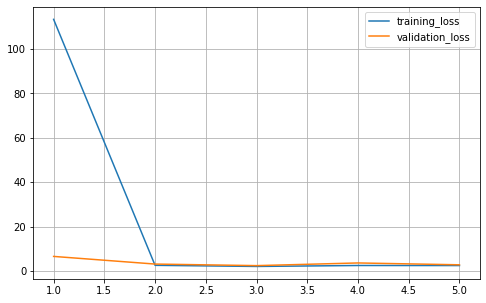

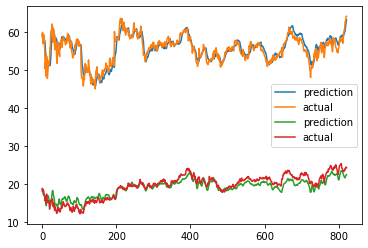

In [55]:

#NASDAQ


# Data preparation for lstm
train = df_Nasdaq.iloc[0:round(0.7*(len(df_Nasdaq.index)))]
test = df_Nasdaq.iloc[round(0.7*(len(df_Nasdaq.index))):]

n_input = 7

X_train, y_train = to_supervised(train, n_input, n_out=1)
X_test, y_test = to_supervised(test, n_input, n_out=1)
alpha = y_train.reshape(y_train.shape[0], y_train.shape[1] * y_train.shape[2])

# define parameters
import keras
verbose, epochs, batch_size = 1, 150, 16 #1,150,16

n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], alpha.shape[1]

# define model

model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features), return_sequences = True, 
               dropout=0.0, recurrent_dropout=0.0, kernel_regularizer=L1L2(0.0, 0.0)))
model.add(LSTM(200, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0))
model.add(Dense(n_outputs))

model.compile(loss='mse', optimizer='adam')


callbacks_list = [
    ModelCheckpoint(
        filepath="LSTM-weights-best.hdf5",
        monitor = 'val_loss',
        save_best_only=True,
        mode='auto',
        verbose=1
        ),
    ReduceLROnPlateau(
        monitor = 'val_loss',
        factor = 0.1,
        patience=3,
        verbose=1
        ),
    EarlyStopping(
        monitor = 'val_loss',
        patience=2,
        verbose=1
        )
    ]

model.summary()


# fit network
history  = model.fit(X_train, alpha, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=0.2,callbacks=callbacks_list,shuffle=True)

model = keras.models.load_model("LSTM-weights-best.hdf5")

#############################################################################################################

train_loss_values = history.history["loss"] #training loss
val_loss_values = history.history["val_loss"] #validation loss
epochs = range(1,len(train_loss_values)+1)

plt.clf()

df = pd.DataFrame(train_loss_values, columns=["training_loss"], index=epochs)
df["validation_loss"] = val_loss_values
title="training loss vs validation loss"
df[['training_loss','validation_loss']].plot(grid=True,figsize=(8,5))
plt.show()


print("val_loss_value: ", val_loss_values[-1])



#############################################################################################################

predictions = list()

# make a forecast

for i in range(X_test.shape[0]):
	# predict the week
	input_x = X_test[i,:,:]
    # reshape into [1, n_input, n]
	input_x = input_x.reshape(1, input_x.shape[0], input_x.shape[1])   
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	yhat_sequence = yhat
	# store the predictions
	predictions.append(yhat_sequence)
# evaluate predictions days for each week
predictions = np.array(predictions)


actual1 = []
actual2 = []
for i in range(y_test.shape[0]):
    actual1.append(y_test[i][0][0])
    actual2.append(y_test[i][0][1])

pred1 = []
pred2 = []
for i in range(predictions.shape[0]):
    pred1.append(predictions[i][0])
    pred2.append(predictions[i][1])

    
plt.plot(pred1,label = "prediction")
plt.plot(actual1, label = "actual")
plt.legend()
plt.plot()

MAE_Score_test1 = mae(actual1,pred1)
print(MAE_Score_test1)


plt.plot(pred2,label = "prediction")
plt.plot(actual2, label = "actual")
plt.legend()
plt.plot()

MAE_Score_test2 = mae(actual2,pred2)
print(MAE_Score_test2)

In [56]:
mse(actual2,pred2)

1.6402179763092302

In [57]:
mse(actual1,pred1)

2.31251022798915